Fitting 5 folds for each of 4 candidates, totalling 20 fits


<ipython-input-3-487441bc4226>:54: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Epoch 1/50
28/28 [==============================] - 1s 2ms/step - loss: 1.7815
Epoch 2/50
28/28 [==============================] - 0s 2ms/step - loss: 1.6637
Epoch 3/50
28/28 [==============================] - 0s 2ms/step - loss: 1.5772
Epoch 4/50
28/28 [==============================] - 0s 2ms/step - loss: 1.5110
Epoch 5/50
28/28 [==============================] - 0s 2ms/step - loss: 1.4676
Epoch 6/50
28/28 [==============================] - 0s 2ms/step - loss: 1.4453
Epoch 7/50
28/28 [==============================] - 0s 2ms/step - loss: 1.4311
Epoch 8/50
28/28 [==============================] - 0s 2ms/step - loss: 1.4191
Epoch 9/50
28/28 [==============================] - 0s 2ms/step - loss: 1.4081
Epoch 10/50
28/28 [==============================] - 0s 2ms/step - loss: 1.3964
Epoch 11/50
28/28 [==============================] - 0s 2ms/step - loss: 1.3878
Epoch 12/50
28/28 [==============================] - 0s 2ms/step - loss: 1.3836
Epoch 13/50
28/28 [==============================

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


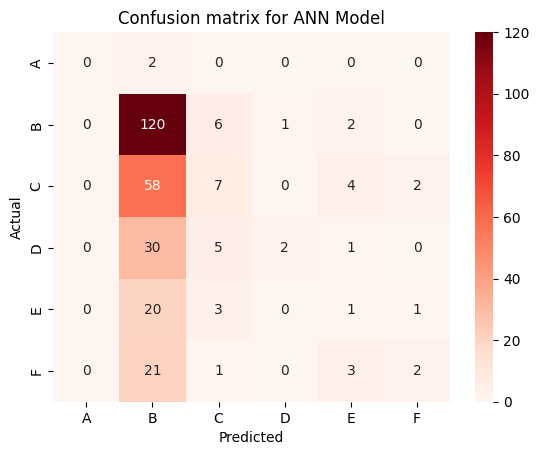

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import matthews_corrcoef, accuracy_score, f1_score, roc_auc_score, classification_report,confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import matthews_corrcoef, make_scorer
# Function to create model architecture
def create_model():
    model = Sequential()
    model.add(Dense(32, input_dim=X_train.shape[1], activation='relu')) #nonlinear transformations on the input data.
    model.add(Dense(16, activation='relu'))
    model.add(Dense(y_train_cat.shape[1], activation='softmax')) #The probability distribution over the classes.
    model.compile(loss='categorical_crossentropy', optimizer='adam') #The sum of all probabilities is equal to 1
    return model

# Load the data
df = pd.read_csv("transformed_dataset.csv") 

# Split the data into predictor variables and target variable
X = df.loc[:, 'Precipitation':'Slope'] 
y = df['Severity_Class']

# Split the data into training and testing sets
#The training and testing sets have similar class distributions for the target variable.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Initialize LabelEncoder
le = LabelEncoder()

# Encode the non-numeric values in y_train
y_train = le.fit_transform(y_train)

# Encode the non-numeric values in y_test
y_test = le.transform(y_test)

# Convert the target variable to categorical data
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Define the hyperparameter grid
#Grid search aims to find a balance between model performance and computational efficiency.
param_grid = {
    'epochs': [20, 50],
    'batch_size': [16, 32],
}

# Create the KerasClassifier wrapper
model = KerasClassifier(build_fn=create_model)

# Use StratifiedKFold for cross-validation
#The model's performance is evaluated on 5 folds, ensuring that each fold represents the original class distribution.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
#Automating the process of hyperparameter tuning and finding the optimal configuration
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=make_scorer(matthews_corrcoef), verbose=1, n_jobs=-1)
grid_search.fit(X_train, np.argmax(y_train_cat, axis=1))


# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Training MCC:", grid_search.best_score_)


# Calculate the evaluation metrics on the test set using the best model
best_model = grid_search.best_estimator_
y_pred = grid_search.best_estimator_.predict(X_test)
y_prob = grid_search.best_estimator_.predict_proba(X_test)
auc_roc = roc_auc_score(y_test, y_prob, average='macro', multi_class='ovo')
test_accuracy = accuracy_score(y_test, y_pred)
print("Test MCC:", matthews_corrcoef(y_test, y_pred))
print("Macro AUC-ROC score:", auc_roc)
print("Test accuracy:", test_accuracy)

clf_report = classification_report(y_test, y_pred)
print("Classification report:\n", clf_report)

conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", conf_mat)
# Plot the confusion matrix using a heatmap
sns.heatmap(conf_mat, annot=True, cmap='Reds', fmt='g', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix for ANN Model')
plt.show()
